In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 80)
pd.set_option('display.max_rows', 100)

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = '/net/pulsar/home/koes/mtr22/gan/torch_training'
os.chdir(expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/torch_training'

In [2]:
template_file = 'train.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=18
#SBATCH --partition=dept_gpu
#SBATCH --gres=gpu:1
#SBATCH --mem=32gb
#SBATCH --time=672:00:00
#SBATCH --qos=normal
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --dependency=singleton
{job_params}
source ~/.bashrc
cd $SLURM_SUBMIT_DIR

python3 $LIGAN_ROOT/train.py \\
    --random_seed {random_seed} \\
    --data_root {data_root} \\
    --rec_molcache {rec_molcache} \\
    --lig_molcache {lig_molcache} \\
    --train_file {train_file} \\
    --test_file {test_file} \\
    --batch_size {batch_size} \\
    --rec_map_file {rec_map_file} \\
    --lig_map_file {lig_map_file} \\
    --model_type {model_type} \\
    --skip_connect {skip_connect} \\
    --kldiv_loss_wt {kldiv_loss_wt} \\
    --recon_loss_wt {recon_loss_wt} \\
    --gan_loss_type {gan_loss_type} \\
    --gan_loss_wt {gan_loss_wt} \\
    --disc_grad_norm {disc_grad_norm} \\
    --max_iter {max_iter} \\
    --test_interval {test_interval} \\
    --n_test_batches {n_test_batches} \\
    --save_interval {save_interval} \\
    --out_prefix {job_name}
'''
with open(template_file, 'w') as f:
    f.write(template)

In [197]:
# for ligand-only models
lig_only_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/mtr22/molport',
    rec_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types',
    skip_connect=False
)

# for receptor-conditional models
rec_cond_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output',
    rec_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2',
    train_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    test_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types',
    skip_connect=True
)

# general parameters
general_param_space = param_search.ParamSpace(
    random_seed=[0, 1, 2],
    batch_size=10,
    rec_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_rec_map',
    lig_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_lig_map',
    kldiv_loss_wt=0.1,
    recon_loss_wt=1,
    gan_loss_wt=10,
    disc_grad_norm_type='2',
    max_iter=100000,
    test_interval=100,
    n_test_batches=10,
    save_interval=10000,
    n_latent=[256, 512, 1024],
)

lig_only_param_space.update(general_param_space)
rec_cond_param_space.update(general_param_space)

# model type-specific parameters
ae_vae_param_space = param_search.ParamSpace(
    model_type=['AE', 'VAE'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='0',
    extra_sbatch_line='',
    **lig_only_param_space,
)

ce_cvae_param_space = param_search.ParamSpace(
    model_type=['CE', 'CVAE'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='0',
    extra_sbatch_line='',
    **rec_cond_param_space,
)

gan_param_space = param_search.ParamSpace(
    model_type=['GAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    extra_sbatch_line='',
    **lig_only_param_space,
)

wgan_param_space = param_search.ParamSpace(
    model_type=['GAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    extra_sbatch_line='',
    **lig_only_param_space,
)

cgan_param_space = param_search.ParamSpace(
    model_type=['CGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    extra_sbatch_line='',
    **rec_cond_param_space,
)

cwgan_param_space = param_search.ParamSpace(
    model_type=['CGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    extra_sbatch_line='',
    **rec_cond_param_space,
)

# dual encoder models require 12gb GPUs

vaegan_param_space = param_search.ParamSpace(
    model_type=['VAEGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    extra_sbatch_line='#SBATCH -C M12',
    **lig_only_param_space,
)

vaewgan_param_space = param_search.ParamSpace(
    model_type=['VAEGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    extra_sbatch_line='#SBATCH -C M12',
    **lig_only_param_space,
)

cvaegan_param_space = param_search.ParamSpace(
    model_type=['CVAEGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    extra_sbatch_line='#SBATCH -C M12',
    **rec_cond_param_space,
)

cvaewgan_param_space = param_search.ParamSpace(
    model_type=['CVAEGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    extra_sbatch_line='#SBATCH -C M12',
    **rec_cond_param_space,
)

all_param_spaces = [
    ae_vae_param_space,
    ce_cvae_param_space,
    gan_param_space,
    wgan_param_space,
    cgan_param_space,
    cwgan_param_space,
    vaegan_param_space,
    vaewgan_param_space,
    cvaegan_param_space,
    cvaewgan_param_space,
]

[len(p) for p in all_param_spaces]

[18, 18, 9, 9, 9, 9, 9, 9, 9, 9]

In [198]:
job_files = param_search.setup(
    expt_dir=expt_dir,
    name_format='train_{model_type}_{n_latent}_{gan_loss_type}_{random_seed}',
    template_file='train.sh',
    param_space=sum(map(list, all_param_spaces), [])
)
job_files

['/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_512_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_256_0_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_512_0_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_1024_0_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_256_0_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_512_0_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_AE_1024_0_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_512_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAE_256_0_1/tr

# Submit training jobs to cluster

In [168]:
job_ids = param_search.submit(job_files)
print(' '.join(map(str,job_ids)))

[6733345, 6733346, 6733347, 6733348, 6733349, 6733350, 6733351, 6733352]

In [ ]:
job_ids = [
    6733823,
    6733824,
    6733825,
    6733826,
    6733874,
    6733875,
    6733876,
    6733877,
]
param_search.status(job=','.join(map(str, job_ids)))

In [179]:
import glob
job_files = dict()
for i in range(10):
    job_files[i] = glob.glob(expt_dir + '/*_{}/train.sh'.format(i))

In [180]:
errors = param_search.errors(job_files[7])
errors

[None, None, None, None, None, None, None, None]

# Read in training output metrics

In [181]:
# READ IN METRIC FILES
metrics = param_search.metrics(job_files[7], metric_pat='(.*)\.metrics')

In [182]:
def dtype(s):
    return s.dtype

metric_index_cols = ['iteration', 'disc_iter', 'phase', 'model', 'batch']
all_index_cols = list(rec_param_space.keys()) + metric_index_cols

metrics[all_index_cols].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
data_root,object,2,"[/net/pulsar/home/koes/mtr22/molport, /net/pulsar/home/koes/paf46/Research/CrossDocking_script/P..."
rec_molcache,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2, /net/pulsar/home/koes/paf46/git..."
lig_molcache,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2, /net/pulsar/home/koes/paf46/git..."
train_file,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types, /net/pulsar/home/koes/paf46..."
test_file,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types, /net/pulsar/home/koes/paf46/..."
model_type,object,8,"[AE, VAE, CE, CVAE, GAN, VAEGAN, CGAN, CVAEGAN]"
skip_connect,bool,2,"[False, True]"
random_seed,int64,1,[0]
batch_size,int64,1,[10]
rec_map_file,object,1,[/net/pulsar/home/koes/mtr22/gan/data/my_rec_map]


In [186]:
#metrics['iteration'] = metrics['iteration'].mask(metrics['iteration'].isna(), metrics['gen_iter'], axis=0)
#metrics['recon_loss_fixed'] = metrics['recon_loss'] * (19*48*48*48) / 2

metrics['model'] = metrics['model'].fillna('gen')
metrics['real'] = metrics['real'].fillna(False)

metrics[
    metrics['iteration'] == metrics.groupby('model_type')['iteration'].transform(max)
].groupby(['model_type', 'iteration', 'phase', 'model'])[
    ['loss', 'kldiv_loss', 'recon_loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm']
].mean()

loss    kldiv_loss    recon_loss  \
model_type iteration phase model                                             
AE         181200    test  gen    6.252360e+01           NaN  6.252360e+01   
CE         148400    test  gen    6.426120e+02           NaN  6.426120e+02   
CGAN       45400     test  disc   3.890164e+35           NaN           NaN   
                           gen   -7.838322e+35           NaN           NaN   
CVAE       110900    test  gen    2.130210e+02  3.189333e+02  1.811277e+02   
CVAEGAN    48300     test  disc   2.616023e+02  3.515785e+02  5.578762e+02   
                           gen   -8.751029e+04  3.556559e+02  5.179729e+02   
GAN        69300     test  disc   7.423684e+36           NaN           NaN   
                           gen   -1.516848e+37           NaN           NaN   
VAE        193800    test  gen    1.214458e+02  3.292007e+02  8.852572e+01   
VAEGAN     53000     test  disc   1.169110e+30  1.123237e+23  3.239788e+27   
                           gen   -2.199093e+30  1.206894e+23  2.753832e+27   

                                      gan_loss  gen_grad_norm  disc_grad_norm  \
model_type iteration phase model                                                
AE         181200    test  gen             NaN    1640.892076             NaN   
CE         148400    test  gen             NaN     959.536213             NaN   
CGAN       45400     test  disc   3.890164e+34            NaN             NaN   
                           gen   -7.838322e+34            NaN             NaN   
CVAE       110900    test  gen             NaN    2674.077952             NaN   
CVAEGAN    48300     test  disc  -3.491406e+00            NaN             NaN   
                           gen   -8.806383e+03            NaN             NaN   
GAN        69300     test  disc   7.423684e+35            NaN             NaN   
                           gen   -1.516848e+36            NaN             NaN   
VAE        193800    test  gen             NaN    1600.614916             NaN   
VAEGAN     53000     test  disc   1.167490e+29            NaN             NaN   
                           gen   -2.201846e+29            NaN             NaN   

                                    lig_norm  lig_gen_norm  
model_type iteration phase model                            
AE         181200    test  gen    121.242378  1.165959e+02  
CE         148400    test  gen    119.343397  4.314380e+01  
CGAN       45400     test  disc   119.944537  8.326793e+18  
                           gen           NaN  8.388308e+18  
CVAE       110900    test  gen    127.366663  1.138464e+02  
CVAEGAN    48300     test  disc   121.902771  1.228411e+02  
                           gen    119.963485  1.200890e+02  
GAN        69300     test  disc   117.716380           inf  
                           gen           NaN           inf  
VAE        193800    test  gen    121.595333  1.150299e+02  
VAEGAN     53000     test  disc   118.665596  2.457418e+14  
                           gen    122.893251  2.305830e+14

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


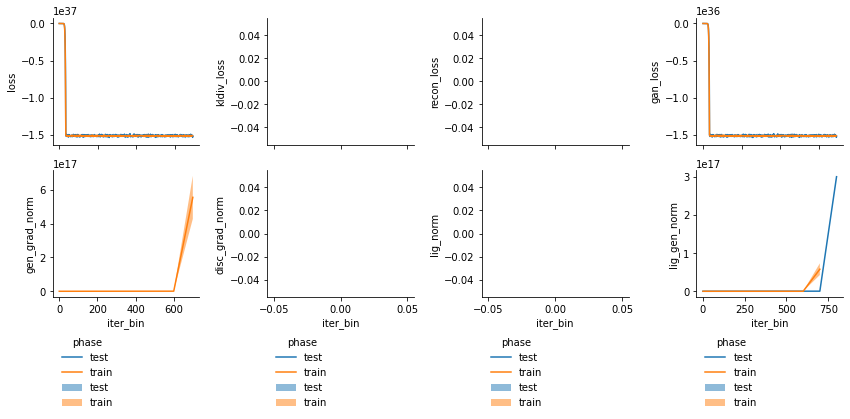

In [189]:
import numpy as np
import scipy.stats
import param_search

def filled_lines(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(scipy.stats.sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h)
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
iter_bin_size = 100
metrics['iter_bin'] = (metrics['iteration'] // 100).astype(int) * iter_bin_size

fig = param_search.plot(
    metrics[
        (metrics['model_type'] == 'GAN') &
        (metrics['model'] != 'disc') &
        (metrics['model'] != 'disc')
    ],
    x='iter_bin',
    y=['loss', 'kldiv_loss', 'recon_loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm'],
    hue='phase',
    plot_func=filled_lines,
    n_cols=4
)